In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.stats import norm

# Define the Newey-West bandwidth function
def newey_west_bandwidth(T):
    return int(np.floor(4 * (T / 100) ** (2 / 9)))

# Diebold-Mariano test function
def diebold_mariano_test(actual, forecast1, forecast2, loss="squared", significance_level=0.05):
    actual, forecast1, forecast2 = np.array(actual), np.array(forecast1), np.array(forecast2)
    
    # Compute forecast errors
    e1 = actual - forecast1
    e2 = actual - forecast2
    
    # Compute loss differentials
    if loss == "squared":
        d = (e1 ** 2) - (e2 ** 2)
    elif loss == "absolute":
        d = np.abs(e1) - np.abs(e2)
    else:
        raise ValueError("Loss function must be 'squared' or 'absolute'")
    
    # Mean of the loss differential
    d_mean = np.mean(d)
    
    # Determine the Newey-West optimal lag
    T = len(d)
    optimal_lag = newey_west_bandwidth(T)
    
    # HAC variance estimation using Bartlett weights
    gamma = [np.sum(d[:T - lag] * d[lag:]) / T for lag in range(optimal_lag + 1)]
    hac_var = gamma[0] + 2 * sum((1 - lag / (optimal_lag + 1)) * gamma[lag] for lag in range(1, optimal_lag + 1))
    
    # Diebold-Mariano statistic
    dm_stat = d_mean / np.sqrt(hac_var / T)
    
    # p-value for two-sided test
    p_value = 2 * (1 - norm.cdf(np.abs(dm_stat)))
    
    return dm_stat, p_value

In [115]:
# Generate forecasts and actual values
np.random.seed(123)
Horizon = 50000
actual = np.random.normal(0, 1, Horizon)
forecast1 = np.random.normal(0, 1, Horizon)
forecast2 = np.random.normal(0, 2, Horizon)
forecast3 = np.random.normal(0, 2, Horizon)
forecast4 = np.random.normal(0, 2, Horizon)
forecast5 = np.random.normal(0, 2, Horizon)
forecast6 = np.random.normal(0, 2, Horizon)
forecast7 = np.random.normal(0, 2, Horizon)

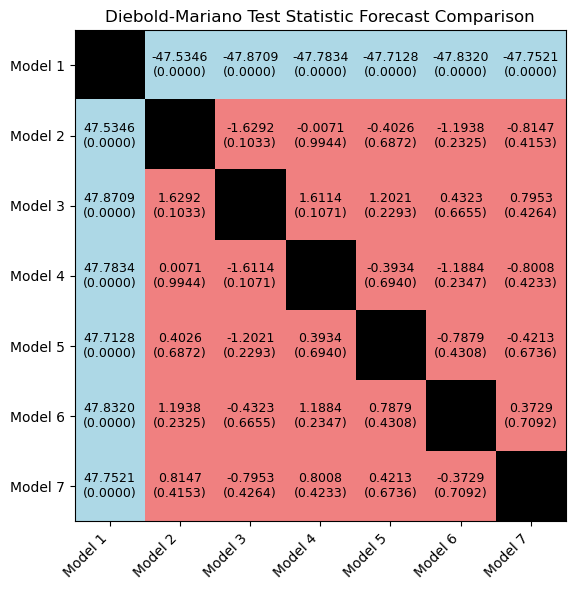

In [126]:

# List of forecasts
forecasts = [forecast1, forecast2, forecast3, forecast4, forecast5, forecast6, forecast7]
forecast_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']

# Create an empty matrix to store the test statistics and p-values
dm_matrix = np.zeros((len(forecasts), len(forecasts)))
p_value_matrix = np.zeros((len(forecasts), len(forecasts)))

# Fill the matrix with Diebold-Mariano test statistics and p-values
for i in range(len(forecasts)):
    for j in range(len(forecasts)):
        if i != j:
            dm_stat, p_value = diebold_mariano_test(actual, forecasts[i], forecasts[j])
            dm_matrix[i, j] = dm_stat
            p_value_matrix[i, j] = p_value

# Convert the matrix to a DataFrame for better readability
dm_df = pd.DataFrame(dm_matrix, index=forecast_names, columns=forecast_names)

# Create a matrix for annotations (don't annotate diagonal)
annot_matrix = np.copy(dm_matrix)
for i in range(len(forecast_names)):
    annot_matrix[i, i] = np.nan  # Remove annotation for diagonal elements

# Set the critical value (you can adjust this depending on your desired confidence level)
critical_value = 1.96  # Example critical value for a 5% significance level

# Create a color matrix based on the conditions
color_matrix = np.zeros(dm_matrix.shape)
for i in range(dm_matrix.shape[0]):
    for j in range(dm_matrix.shape[1]):
        if i != j:
            if np.abs(dm_matrix[i, j]) <= critical_value:
                color_matrix[i, j] = 0  # light grey for in-range values
            else:
                color_matrix[i, j] = 1  # dark grey for out-of-range values
        else:
            color_matrix[i, j] = 2  # black for diagonal elements

# Define custom colormap: 0 for lightred, 1 for lightblue, and 2 for black
cmap = ListedColormap(['lightcoral', 'lightblue', 'black'])

# Create the heatmap using plt
plt.figure(figsize=(8, 6))

# Create the matrix plot using imshow, with the custom color mapping
cax = plt.imshow(color_matrix, cmap=cmap, interpolation='nearest')

# Add annotations
for i in range(dm_matrix.shape[0]):
    for j in range(dm_matrix.shape[1]):
        if i != j:  # Don't annotate the diagonal
            dm_stat = dm_matrix[i, j]
            p_value = p_value_matrix[i, j]
            # Annotate with test statistic and p-value underneath in smaller font
            plt.text(j, i, f"{dm_stat:.4f}\n({p_value:.4f})", ha='center', va='center', color='black', fontsize=9)

# Add labels
plt.xticks(np.arange(len(forecast_names)), forecast_names, rotation=45, ha="right")
plt.yticks(np.arange(len(forecast_names)), forecast_names)

# Title and show plot
plt.title("Diebold-Mariano Test Statistic Forecast Comparison")
plt.tight_layout()  # Ensure everything fits well
plt.show()
